In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
import copy

setup geometry

In [2]:
geo = SplineGeometry()
geo.AddRectangle( (-3,-2), (3, 2), bcs = ("top", "out", "bot", "in"))
geo.AddCircle ( (0, 0), r=0.5, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.2))
mesh.Curve(3);
geo_1 = SplineGeometry()
geo_1.AddRectangle((0,0),(1,1))
mesh_1 = Mesh(geo_1.GenerateMesh())
#Draw(mesh)

setup FEM space

In [3]:
# viscosity
nu = 0.01
# Order of spaces
k = 2
# H1 vs VectorH1 -> vector field?!
V = H1(mesh,order=k, dirichlet="top|bot|cyl|in|out")
Q = H1(mesh,order=k-1)
FES = FESpace([V,V,Q]) # X = [V,Q] (without VectorH1)

setup bilinear form
velocityfield u and pressurefield p

In [4]:
ux,uy,p = FES.TrialFunction()
vx,vy,q = FES.TestFunction()

# stokes equation
def Equation(ux,uy,p,vx,vy,q):
    div_u = grad(ux)[0]+grad(uy)[1] # custom div
    div_v = grad(vx)[0]+grad(vy)[1]
    return (grad(ux)*grad(vx)+grad(uy)*grad(vy) + div_u*q + div_v*p) * dx


# (InnerProduct(grad(u),grad(v))+div(u)*q+div(v)*p)*dx
a = BilinearForm(FES)
a += Equation(ux,uy,p,vx,vy,q)
a.Assemble()

setup boundary conditions

In [5]:
gfu = GridFunction(FES)
uinf = 0.001
uin = CoefficientFunction((uinf))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("in|top|bot|out"))

x_velocity = CoefficientFunction(gfu.components[0])
scene_state = Draw(x_velocity, mesh, "vel")

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

solve stokes

In [6]:
def solveStokes():
    res = gfu.vec.CreateVector()
    res.data = -a.mat * gfu.vec
    inv = a.mat.Inverse(FES.FreeDofs())
    gfu.vec.data += inv * res
    scene_state.Redraw()
solveStokes()

# Calculations/Setup for all the side constraints

Drag/ "dissipated energy" [should be working]

$J(\Omega ) = \frac{1}{2} \int_\Omega Du : Du dx$ 

In [7]:
def calc_drag(gfu):
    ux = gfu.components[0]
    uy = gfu.components[1]
    return 0.5*(grad(ux)*grad(ux)+grad(uy)*grad(uy))*dx

### get surface area of mesh (main issue)
$vol(\Omega) = \int_{\Omega} 1 \,dx \in \mathbb{R}$ should stay constant <br>
entire area: $A = 6*4=24$ <br>
$\alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2$

In [8]:
alpha = 1e-4
surf_t = CoefficientFunction(1)
surf_0 = Integrate(surf_t,mesh)

def calc_surf_change():
    return alpha*(surf_t*dx-surf_0)**2

### barycenter (not necessarily useful yet)
$bc^\Omega = \frac{1}{vol(\Omega)}\int_{\Omega}x\,dx \in \mathbb{R}^d$ for each dimension!!

In [9]:
bc_tx = CoefficientFunction(x)
bc_ty = CoefficientFunction(y)
bc_0x = 1/surf_0*Integrate(bc_tx,mesh)
bc_0y = 1/surf_0*Integrate(bc_ty,mesh)

bc_0 = (1/surf_0)*Integrate(bc_tx,mesh)

def calc_bc_change():
    return ((1/(surf_t*dx))*(bc_t*dx)- bc_0)

In [10]:
def Cost(gfu):
    return calc_drag(gfu) + calc_surf_change()# + calc_bc_change()

# creation of Shapediff Space + pertubation Function
function that will perturb our mesh

In [11]:
# Test and trial functions for shape derivate -> do we even need this?
VEC = H1(mesh, order=2, dim=2, dirichlet="top|bot|in|out")
PHI, X = VEC.TnT()
# gfset denotes the deformation of the original domain and will be updated during the shape optimization
gfset = GridFunction(VEC)
gfset.Set((0,0))
mesh.SetDeformation(gfset)
SetVisualization (deformation=True)

# deformation calculation
gfX = GridFunction(VEC)

In [12]:
# try for already transformed cost function:
n = specialcf.normal(2)
def TransfCost():
    #return div(X)**2*dx
    return (gfX*n)**2*ds(definedon="cyl")

# Shape Optimization
$\min_{h,u,s} \int_{\Omega(s)} \sum_{i,j=1}^2 \left( \frac{\partial u_i}{\partial x_j}\right)^2~\mathrm{d} x
 + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s))-\mathrm{Bc}_j(\Omega_0)\Big)^2,$

$\frac{1}{2} \int_\Omega Du : Du dx + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s)) - \mathrm{Bc}_j(\Omega_0)\Big)^2,$ (1)

In [13]:
# trying out different stuff for float/SumOfIntegrals Subtraction
surf_init = Parameter(surf_0)
surf_in = CoefficientFunction(surf_0)
surfdif = (CoefficientFunction(1)*dx(definedon="mesh_orig") - CoefficientFunction(1) * dx(definedon="mesh"))

In [14]:
ux = gfu.components[0]
uy = gfu.components[1]
p = gfu.components[2]

vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))

Lagrangian = Equation(ux,uy,p,ux,uy,p) + calc_drag(gfu)

In [15]:
dJOmega = LinearForm(VEC)
dJOmega += Lagrangian.DiffShape(X)

# volume side constraint
vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))
alpha = 1e-4
dJOmega += (alpha*((vol-surf_0)**2)*dx).DiffShape(X) # (definedon="mesh_1")

# barycenter x sideconstraint
beta = 1e-4
bc_x = Parameter(1)
bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
dJOmega += (beta*((bc_x-bc_0x)**2)*dx).DiffShape(X)

# barycenter x sideconstraint
bc_y = Parameter(1)
bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
dJOmega += (beta*((bc_y-bc_0y)**2)*dx).DiffShape(X)

b = BilinearForm(VEC)
b += InnerProduct(grad(X),grad(PHI))*dx + InnerProduct(X,PHI)*dx # H1 InnerProduct

In [16]:
def updateParams(v=False):
    vol.Set(Integrate(surf_t,mesh))
    bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
    bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
    if(v):
        print(vol.Get(), bc_x.Get(), bc_y.Get())
updateParams()

## this basically just copy paste

In [17]:
def SolveDeformationEquation():
    rhs = gfX.vec.CreateVector()
    rhs.data = dJOmega.vec - b.mat * gfX.vec
    update = gfX.vec.CreateVector()
    update.data = b.mat.Inverse(VEC.FreeDofs()) * rhs
    gfX.vec.data += update

In [18]:
scene = Draw(gfset)

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

In [58]:
gfset.Set((0,0))
mesh.SetDeformation(gfset)
scene.Redraw()
a.Assemble()
solveStokes()

data = [[] for x in range(6)]
LineSearch = False

iter_max = 400
Jold = Integrate(calc_drag(gfu), mesh)+1e-10
converged = False

# try parts of loop
mesh.SetDeformation(gfset)
scene.Redraw()

print('cost at iteration', k, ': ', Jold)
    
# input("Press enter to start optimization")
for k in range(iter_max):
    mesh.SetDeformation(gfset)
    scene.Redraw()
    scene_state.Redraw()
    
    print('drag at iteration', k, ': ', Jold)
    titles = ["drag","volume","bc_x","bc_y","scale","Jdiff"] # collecting data
    data[0].append(Integrate(calc_drag(gfu),mesh))
    data[1].append(vol.Get())
    data[2].append(bc_x.Get())
    data[3].append(bc_y.Get())
    
    a.Assemble()
    solveStokes()
    
    b.Assemble()
    dJOmega.Assemble()
    SolveDeformationEquation()
    updateParams()
    
    Jnew = Integrate(calc_drag(gfu), mesh)
    mesh.UnsetDeformation()
    
    #scale = 0.1 / Norm(gfX.vec)
    scale = 0.01 / Norm(gfX.vec)
    data[4].append(scale)
    jdiff = abs(Jnew-Jold)
    data[5].append(jdiff)
    if(jdiff < 1e-11):
        if alpha < 1e5:
            alpha = alpha*2
            beta = beta*2
        else:
            print("alpha to big")
            break
    if(jdiff < 1e-12):
        print("jdiff small")
        break
    
    gfsetOld = gfset
    gfset.vec.data -= scale * gfX.vec
    Jold = Jnew

    Redraw(blocking=True)

cost at iteration 150 :  1.0997930056224474e-05
drag at iteration 0 :  1.0997930056224474e-05
drag at iteration 1 :  1.0997830056224485e-05
drag at iteration 2 :  1.0950672245562612e-05
drag at iteration 3 :  1.089130309625119e-05
drag at iteration 4 :  1.0832311898109152e-05
drag at iteration 5 :  1.0773696392141967e-05
drag at iteration 6 :  1.0715454278160446e-05
drag at iteration 7 :  1.0657583291539706e-05
drag at iteration 8 :  1.0600081204199068e-05
drag at iteration 9 :  1.0542945825439096e-05
drag at iteration 10 :  1.0486175002747658e-05
drag at iteration 11 :  1.0429766622473139e-05
drag at iteration 12 :  1.0373718610432851e-05
drag at iteration 13 :  1.0318028932439606e-05
drag at iteration 14 :  1.026269559475359e-05
drag at iteration 15 :  1.0207716644463747e-05
drag at iteration 16 :  1.0153090169802271e-05
drag at iteration 17 :  1.0098814300396366e-05
drag at iteration 18 :  1.0044887207461058e-05
drag at iteration 19 :  9.991307103936207e-06
drag at iteration 20 :  9

drag at iteration 176 :  6.065402733881576e-06
drag at iteration 177 :  6.066521340612322e-06
drag at iteration 178 :  6.067635482626386e-06
drag at iteration 179 :  6.068744497805751e-06
drag at iteration 180 :  6.06984782630846e-06
drag at iteration 181 :  6.0709449981662325e-06
drag at iteration 182 :  6.072035622367554e-06
drag at iteration 183 :  6.073119377264792e-06
drag at iteration 184 :  6.07419600215469e-06
drag at iteration 185 :  6.075265289902791e-06
drag at iteration 186 :  6.076327080489692e-06
drag at iteration 187 :  6.0773812553773124e-06
drag at iteration 188 :  6.078427732602423e-06
drag at iteration 189 :  6.079466462514701e-06
drag at iteration 190 :  6.0804974240851095e-06
drag at iteration 191 :  6.081520621725859e-06
drag at iteration 192 :  6.0825360825640545e-06
drag at iteration 193 :  6.0835438541199665e-06
drag at iteration 194 :  6.084544002349404e-06
drag at iteration 195 :  6.085536610021885e-06
drag at iteration 196 :  6.086521775395172e-06
drag at it

drag at iteration 350 :  6.891943971349245e-06
drag at iteration 351 :  6.942078320967469e-06
drag at iteration 352 :  7.160689682270756e-06
drag at iteration 353 :  7.999298231645211e-06
drag at iteration 354 :  1.0575106856488264e-05
drag at iteration 355 :  7.871865357172051e-06
drag at iteration 356 :  8.569191522470442e-06
drag at iteration 357 :  1.0301323611348924e-05
drag at iteration 358 :  7.948132812912612e-06
drag at iteration 359 :  8.539812147120038e-06
drag at iteration 360 :  1.0531982806055324e-05
drag at iteration 361 :  7.511931121938371e-06
drag at iteration 362 :  7.0545656626018e-06
drag at iteration 363 :  6.851640605052279e-06
drag at iteration 364 :  6.732056156129258e-06
drag at iteration 365 :  6.651486812327191e-06
drag at iteration 366 :  6.592811016651992e-06
drag at iteration 367 :  6.547850272117356e-06
drag at iteration 368 :  6.512140564126887e-06
drag at iteration 369 :  6.483011184323188e-06
drag at iteration 370 :  6.45875354565381e-06
drag at itera

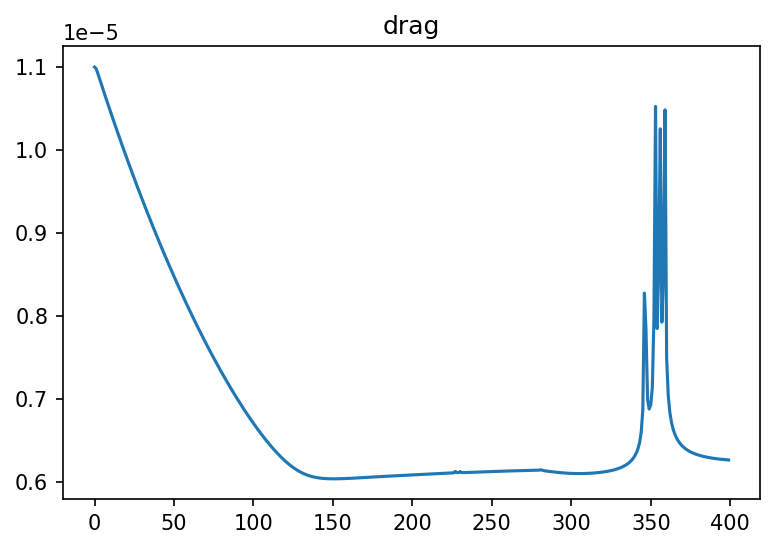

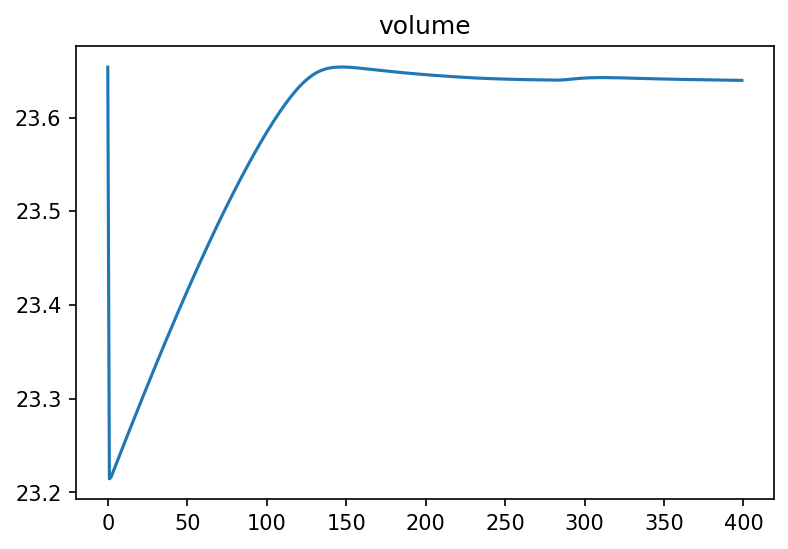

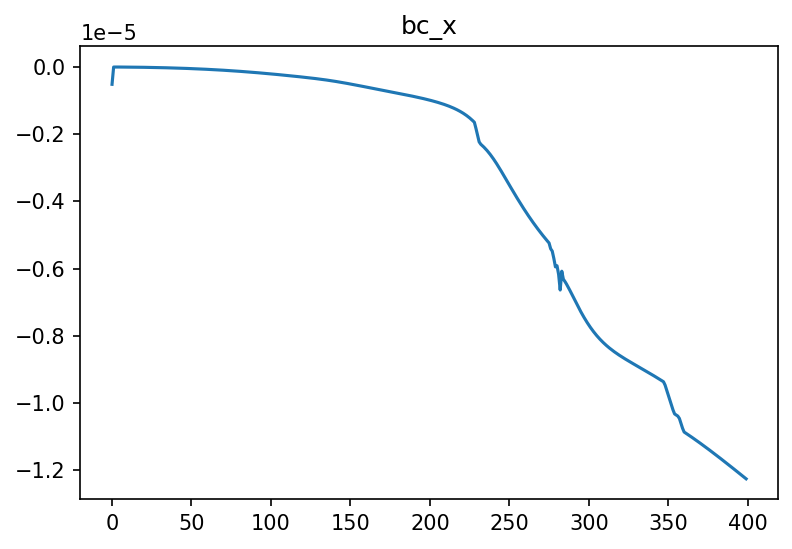

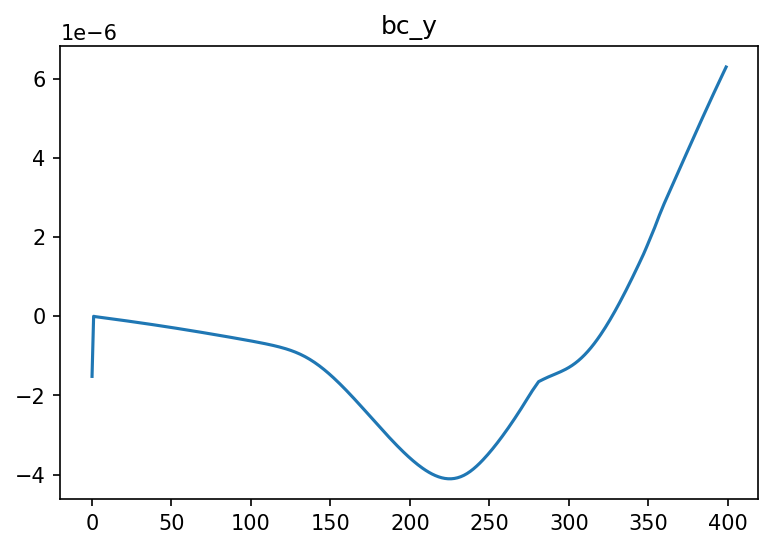

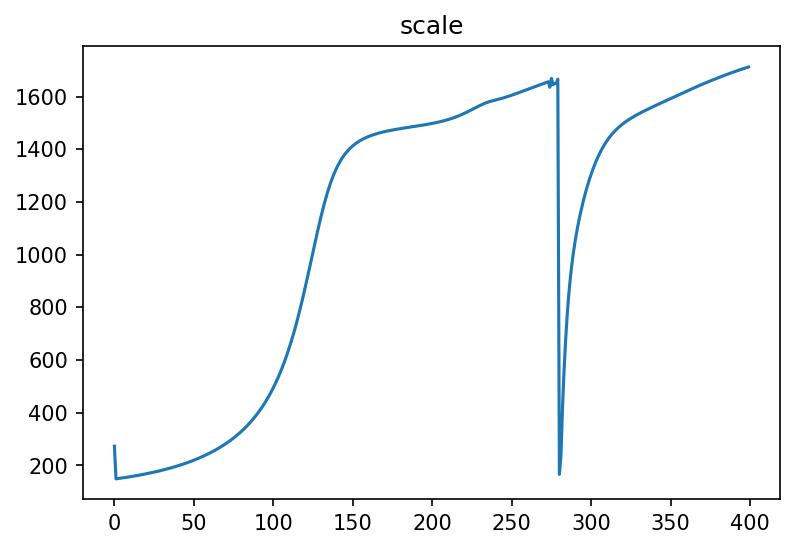

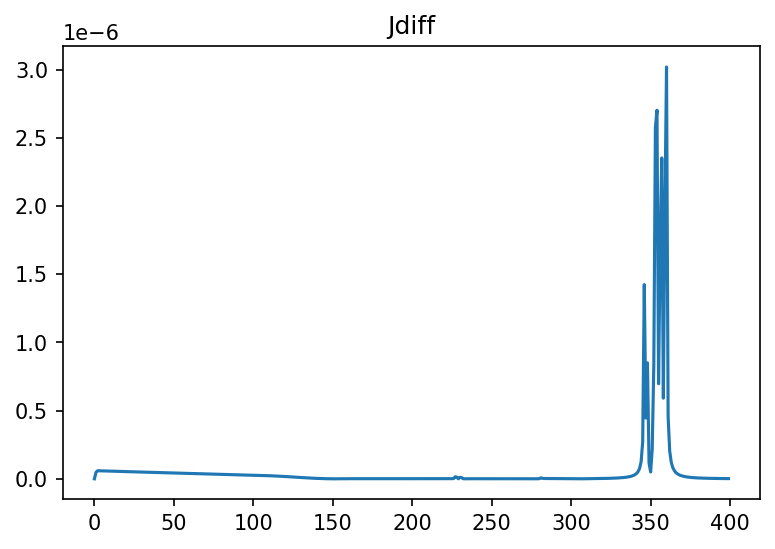

In [60]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
c = 0
for e in data:
    plt.figure(c)
    plt.title(titles[c])
    plt.plot(range(len(e)),e)
    c += 1

ValueError: x and y must have same first dimension, but have shapes (300,) and (151,)

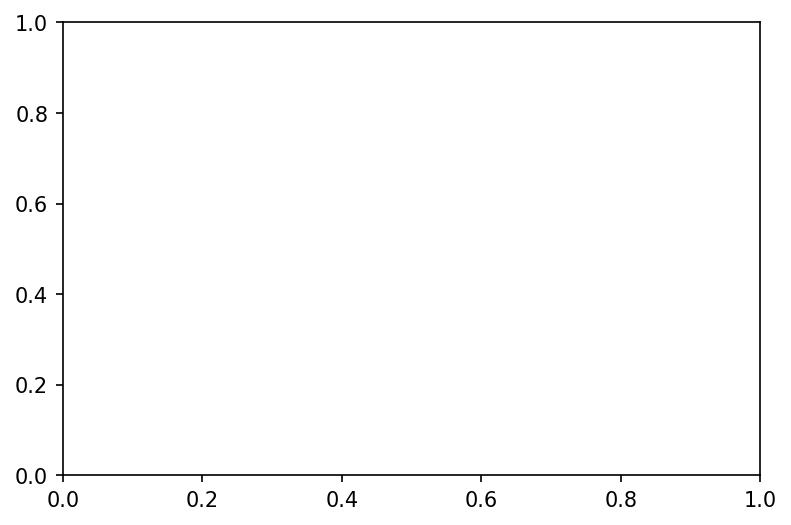

In [56]:
#print([x*1e8 for x in data[5][340:375]])
plt.plot(range(300),data[5][:300])
print(data[5][200]-data[5][201])
print(alpha)

[1.0000000000530147e-10, 4.715485929124465e-08, 5.936916155314561e-08, 5.899121034892746e-08, 5.8615518122644784e-08, 5.824212608945034e-08, 5.787099868195464e-08, 5.750209936809423e-08, 5.713539074849136e-08, 5.677083464785559e-08, 5.640839220270764e-08, 5.604802394405994e-08, 5.5689689876414324e-08, 5.5333349552328035e-08, 5.497896214311048e-08, 5.462648650534072e-08, 5.427588124407648e-08, 5.392710477150099e-08, 5.3580115362620497e-08, 5.3234871207436405e-08, 5.2891330458960196e-08, 5.254945127867537e-08, 5.2209191878333454e-08, 5.187051055833304e-08, 5.153336574365095e-08, 5.1197716015834654e-08, 5.0863520142851713e-08, 5.05307371050073e-08, 5.019932611904228e-08, 4.9869246658277346e-08, 4.9540458470546416e-08, 4.921292159311286e-08, 4.8886596364616075e-08, 4.856144343416013e-08, 4.823742376770718e-08, 4.791449865128773e-08, 4.759262969166807e-08, 4.7271778813270495e-08, 4.6951908253175785e-08, 4.66329805517652e-08, 4.6314958541148314e-08, 4.5997805329791054e-08, 4.568148428363534e